In [1]:
import numpy as np
import time
import itertools
from pylab import *
from l2distance import l2distance
import numpy.random as random

from utils import *

from visualization import *
from Buckets import *
from analyze import *
from cvxopt.modeling import *
from cvxpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%load_ext line_profiler


from ipywidgets import *




In [2]:
def dp_check_sum(nums, target):
    """
    Given a set of numbers, check if there is a subset set S, 
    such that sum(S_i) < eps
    
    return:
    true or false
    
    nums: a 1-D array, a set of numbers, must be sorted
    target: a 1-D array, the target sum.    
    
    """
    np.sort(nums)
    A = np.sum(nums[nums>0])
    B = np.sum(nums[nums<0])
    
    if target < B  or target > A:
        return 0
    
    dp = np.zeros([len(nums), A - B + 1])
    
    for i in range(A - B + 1):
        dp[0][i] = (nums[0] == i + B) * 1
    
    for i in range(1, len(nums),1):
        for j in range(A - B + 1):
            if (nums[i] == j + B):
                dp[i][j] = 1
            if (dp[i - 1][j] == 1):
                dp[i][j] = 1
            if (dp[i - 1][j - nums[i]] == 1):
                dp[i][j] = 1
    return dp[len(nums) - 1][target - B]




In [3]:
def dp_check_sum_float(nums, target, delta, eps):
    """
    Given a set of numbers, check if there is a subset set S, 
    such that abs(sum(S_i) - target) < eps
    
    return:
    true or false
    
    nums: a 1-D array, a set of numbers, must be sorted
    target: a 1-D array, the target sum.    
    
    """
    np.sort(nums)
    A = np.sum(nums[nums>0])
    B = np.sum(nums[nums<0])
        
    n = int(np.round((A - B + delta) / delta, 0))
    
    idx = int(np.round((target - B) / delta, 0))
    if idx < 0 or idx > n:
        return 0

    dp = np.zeros([len(nums), n])
    
    for i in range(n):
        dp[0][i] = (np.abs(nums[0]-(i + B) * delta) < eps ) * 1
    
    for i in range(1, len(nums),1):
        for j in range(n):
            if (np.abs(nums[i]- delta * (j + B)) < eps):
                dp[i][j] = 1
            if (dp[i - 1][j] == 1):
                dp[i][j] = 1
            if (dp[i - 1][int(np.round(j * delta - nums[i],0))] == 1):
                dp[i][j] = 1
    return dp[len(nums) - 1][int(np.round((target - B) / delta, 0))]



dp_check_sum_float(np.array([-0.1,0.1,0.2,0.3]), 0.55, 0.1,0.03)

0.0

In [4]:
def combination_sum(force, energy, targetF, targetE, eps,three_states=False):
    """
    Given a set of force, find a subset set S of it,
    such that sum(abs(sign_i F[S_i])) < eps, and sum(sign_i E[S_i]) < targetE)
    
    return:
    (1) a list of selected index : S_i
    (2) a list of corresponding sign for S_i: sign_i

   
    force: a 1-D array
    energy: a 1-D array
    
    targetF: the target value of net force
    targetE: the upper bound of sum of energy
    
    three_states: boolean
    
    eps: the maxium difference between the solution sum with the target.
    
    """
    res=[]
    curlist = []
    curF = 0
    curE = 0
    
    dfs(0, force, energy, targetF, targetE, res, curF, curE, curlist, eps,three_states) 
    
    idx_list=[]
    sign_list=[]
    for l in res:
        l = np.asarray(l)
        idx_list.append( np.abs(l) - 1)
        sign_list.append(np.sign(l))
    return idx_list, sign_list
    


def dfs(idx, force, energy, targetF, targetE, res, curF, curE, curlist,eps, three_states):        
    """
    base case 
    """
    if (np.abs(curF -targetF) < eps and len(curlist) > 0 and curE < targetE):
         res.append(list.copy(curlist))
    if (idx >= len(force)):
        return
    """
    recursion
    """
    length = len(curlist)
       
    # select current number, assign +1 as the sign
    curlist.append(idx+1)
    

    dfs(idx+1,force,energy,targetF, targetE, res, curF+force[idx], curE+energy[idx],curlist,eps,three_states)
    curlist = curlist[:length]
    
    # select current number, assign -1 as the sign
    curlist.append(-idx-1)
    dfs(idx+1,force,energy,targetF, targetE, res, curF-force[idx], curE-energy[idx],curlist,eps,three_states)    
    curlist = curlist[:length]
    
    # do nothing
    if three_states:
        dfs(idx+1,force,energy,targetF, targetE, res, curF, curE,curlist,eps,three_states)    

    curlist = curlist[:length]



In [5]:
def combination_sum_pads(N, force, energy, targetF, targetE, eps,three_states=False):
    """
    Given a set of force, find a subset set S of it,
    such that sum(abs(sign_i F[S_i])) < eps, and sum(sign_i E[S_i]) < targetE)
    
    return:
    (1) a list of selected index : S_i
    (2) a list of corresponding sign for S_i: sign_i

   
    force: a 1-D array
    energy: a 1-D array
    
    targetF: the target value of net force
    targetE: the upper bound of sum of energy
    
    three_states: boolean
    
    eps: the maxium difference between the solution sum with the target.
    
    """
    pad1 = np.zeros([N * N])
    pad2 = np.zeros([N * N])
    
    res=[]
    curlist = []
    curF = 0
    curE = 0
    dfs_pads(0, pad1, pad2, force, energy, curF, curE, targetF, targetE, res, eps) 
    
    return res


def dfs_pads(idx, pad1, pad2, force, energy, curF, curE, targetF, targetE, res, eps):
    #if idx == len(pad1):
    #print(pad1, pad2, curF, curE)
    if (idx >= len(pad1) and np.abs(curF - targetF) <= eps and curE < targetE):
        res.append([np.copy(pad1),np.copy(pad2),curF,curE])
        return
    if (idx >= len(pad1)):
        return
    
    pad1[idx]=1
    pad2[idx]=1

    dfs_pads(idx+1,pad1,pad2,force,energy,
             curF+np.sum(force[idx]*pad1[idx]*pad2+force[:,idx]*pad1*pad2[idx])-force[idx][idx],
             curE+np.sum(energy[idx]*pad1[idx]*pad2+energy[:,idx]*pad1*pad2[idx])-energy[idx][idx],
             targetF,targetE,res,eps)
    
    #pad1[idx]=1
    pad2[idx]=-1
    dfs_pads(idx+1,pad1,pad2,force,energy,
             curF+np.sum(force[idx]*pad1[idx]*pad2+force[:,idx]*pad1*pad2[idx])+force[idx][idx],
             curE+np.sum(energy[idx]*pad1[idx]*pad2+energy[:,idx]*pad1*pad2[idx])+energy[idx][idx],
             targetF,targetE,res,eps)
    
    pad1[idx]=-1
    pad2[idx]=1
    dfs_pads(idx+1,pad1,pad2,force,energy,
             curF+np.sum(force[idx]*pad1[idx]*pad2+force[:,idx]*pad1*pad2[idx])+force[idx][idx],
             curE+np.sum(energy[idx]*pad1[idx]*pad2+energy[:,idx]*pad1*pad2[idx])+energy[idx][idx],
             targetF,targetE,res,eps)

    #pad1[idx]=-1
    pad2[idx]=-1
    dfs_pads(idx+1,pad1,pad2,force,energy,
             curF+np.sum(force[idx]*pad1[idx]*pad2+force[:,idx]*pad1*pad2[idx])-force[idx][idx],
             curE+np.sum(energy[idx]*pad1[idx]*pad2+energy[:,idx]*pad1*pad2[idx])-energy[idx][idx],
             targetF,targetE,res,eps)
    
    pad1[idx]=0
    pad2[idx]=0

In [6]:
def initialize_buckets(interaction_tensor_2D):
    """
    generate the unique dx^2 + dy^2 value and position for a given interaction_tensor_2D.
    INPUT:
    interaction_tensor_2D, a 2D array, the pairwise dx^2 + dy^2
    
    OUTPUT:
    unique_x2y2: a 1D array, contains the sorted unique value of dx^2 + dy^2 in the interaction_tensor_2D.
    num_unique_x2y2: a 3D array, first dimension is len(unique_x2y2), each dimension corresponding to a dx^2+dy^2 value,
    each dimension contains a 2D binary array that has the same shape as interaction_tensor_2D, indicating the position 
    where interaction_tensor_2D has the dx^2+dy^2 value.
    """
    unique_x2y2 = np.unique(interaction_tensor_2D)
    idx_unique_x2y2 = np.empty([len(unique_x2y2),interaction_tensor_2D.shape[0], interaction_tensor_2D.shape[1]])
    i=0
    for x2y2 in unique_x2y2:
        idx_unique_x2y2[i] = (interaction_tensor_2D == x2y2)
        i+=1
    return unique_x2y2, idx_unique_x2y2

def single_dipole_buckets(idx_unique_x2y2, pad1, pad2):
    """
    given two pads, pads[i] and pads[j], and the idx_unique_x2y2, fill in the buckets.
        
    INPUT:
    idx_unique_x2y2, a 3D array, computed from initialize_buckets function
    pads: a list of pads
    i, integer, the index of the first pad
    j, integer, the index of the second pad
    
    OUTPUT:
    buckets: a 1D array, same shape as idx_unique_x2y2, k-th element represents the net number of k-th dx^2+dy^2
    appears in given pads interactions. 
    """
    buckets = np.zeros([len(idx_unique_x2y2)])
    outer_product = np.outer(pad1, pad2)    
    buckets[0] = np.sum(np.diag(outer_product)) 
    outer_product = outer_product.reshape(1, len(outer_product), len(outer_product))
    buckets[1:] = np.sum(np.sum(outer_product * idx_unique_x2y2[1:], axis=1), axis=1)
    return buckets

def outerToBucket(outer_product, idx_unique_x2y2):
    buckets = np.zeros([len(idx_unique_x2y2)]).astype('int32')
   
    buckets[0] = np.sum(np.diag(outer_product))
    outer_product = outer_product.reshape(1, len(outer_product), len(outer_product))
   
    
    buckets[1:] = np.sum(np.sum(outer_product * idx_unique_x2y2[1:], axis=1), axis=1)
    return buckets
    

In [7]:
def hash_bucket(bucket, base):
    """
    only applies to under 4by4, hash a bucket into a 32-bit integer
    """
    hashval = 0
    for j in range(len(bucket) - 1):
        i = bucket[j]
        hashval = hashval * 100 + (i +  base[j])
    hashval = hashval * 100 + bucket[-1] + base[-1]
    return hashval



def backout_bucket(hashval, base):
    bucket = np.zeros([len(base)])
    for i in range(len(bucket)):
        tmp = hashval % 100
        bucket[len(bucket) - i - 1] = tmp - base[len(bucket) - i - 1]
        hashval = int(hashval / 100)
    return bucket

hash_bucket([2,0,2],[8,16,8])
backout_bucket(hash_bucket([3,6,6],[8,16,8]),[8,16,8])

array([3., 6., 6.])

In [8]:
def combination_unique_pads(N, idxlist, three_states=False):
    """
    Given a set of force, find a subset set S of it,
    such that sum(abs(sign_i F[S_i])) < eps, and sum(sign_i E[S_i]) < targetE)
    
    return:
    (1) a list of selected index : S_i
    (2) a list of corresponding sign for S_i: sign_i

   
    force: a 1-D array
    energy: a 1-D array
    
    targetF: the target value of net force
    targetE: the upper bound of sum of energy
    
    three_states: boolean
    
    eps: the maxium difference between the solution sum with the target.
    
    """
    pad1 = np.zeros([N * N])
    pad2 = np.zeros([N * N])
    global base_bucket
    base_bucket = outerToBucket(np.outer(np.ones([N*N]),np.ones([N*N])),idxlist)
    res=set()
    curlist = []
    curF = 0
    curE = 0
    dfs_unique_pads(0, pad1, pad2, res, np.zeros([N*N, N*N])) 
    
    return res


def dfs_unique_pads(idx, pad1, pad2, res, outerproduct):
    global idxlist,base_bucket
    #if (np.all(np.outer(pad1,pad2)!= outerproduct)):
    #    print(pad1, pad2, outerproduct)

    if (idx == len(pad1)):
        #if (np.any(np.outer(pad1, pad2) != outerproduct)):

         #   print(pad1, pad2)
         #   print(outerproduct)
        
        bucket = outerToBucket(outerproduct,idxlist)
        res.add(hash_bucket(bucket, base_bucket ))
        #res.add(str(bucket))
        return
   
    
    pre = outerproduct
    
    pad1[idx]=1
    pad2[idx]=1
    outerproduct[idx] = pad1[idx] * pad2
    outerproduct[:,idx] = pad2[idx] * pad1
    outerproduct[idx][idx]=1
    dfs_unique_pads(idx+1,pad1,pad2, res, outerproduct)
    
    
    #pad1[idx]=1
    pad2[idx]=-1
    outerproduct[idx] = pad1[idx] * pad2
    outerproduct[:,idx] = pad2[idx] * pad1
    outerproduct[idx][idx]=-1
    dfs_unique_pads(idx+1,pad1,pad2,res, outerproduct)
    
    pad1[idx]=-1
    #pad2[idx]=-1
    outerproduct[idx] = pad1[idx] * pad2
    outerproduct[:,idx] = pad2[idx] * pad1
    outerproduct[idx][idx]=1
    dfs_unique_pads(idx+1,pad1,pad2,res, outerproduct)    
    
    #pad1[idx]=-1
    pad2[idx]=1
    outerproduct[idx] = pad1[idx] * pad2
    outerproduct[:,idx] = pad2[idx] * pad1
    outerproduct[idx][idx]=-1
    dfs_unique_pads(idx+1,pad1,pad2,res, outerproduct)
    
    pad1[idx]=0
    pad2[idx]=0
    outerproduct = pre

In [21]:
N=3
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads(N, idxlist, three_states=False)
e=time.time()
print(len(res),e-s)

4366 9.887645244598389


In [120]:
N=3
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
outerToBucket(np.outer(np.ones([N*N]),np.ones([N*N])),idxlist)

array([ 9, 24, 16, 12, 16,  4], dtype=int32)

In [27]:
dlist

array([], dtype=float64)

In [37]:
assignments = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
#assignments = [[-1,-1],[-1,1],[1,-1],[1,1]]
def combination_unique_pads_threeStates(N, idxlist):
    """
    Given a set of force, find a subset set S of it,
    such that sum(abs(sign_i F[S_i])) < eps, and sum(sign_i E[S_i]) < targetE)
    
    return:
    (1) a list of selected index : S_i
    (2) a list of corresponding sign for S_i: sign_i

   
    force: a 1-D array
    energy: a 1-D array
    
    targetF: the target value of net force
    targetE: the upper bound of sum of energy
    
    three_states: boolean
    
    eps: the maxium difference between the solution sum with the target.
    
    """
    pad1 = np.zeros([N * N]).astype('int8')
    pad2 = np.zeros([N * N]).astype('int8')
    global base_bucket
    base_bucket = outerToBucket(np.outer(np.ones([N*N]),np.ones([N*N])),idxlist)
    res=set()
    dfs_unique_pads_threeStates(0, pad1, pad2, res)     
    return res


def dfs_unique_pads_threeStates(idx, pad1, pad2, res):
    global idxlist,base_bucket,assignments
    global x2y2list, two_extrema, dlist
    bucket = outerToBucket(np.outer(pad1,pad2),idxlist)    
    
    hashval=hash_bucket(bucket, base_bucket)
    if not hashval in res:
        
        res.add(hashval)
        
        pes = combination_of_single_dipole(x2y2list, bucket, dlist, single_dipole_energy)
        info=extrema_info(pes,dlist)
        if (len(info)>1):
            two_extrema.append([np.copy(pad1),np.copy(pad2)])
        
        #res.add(str(bucket))
        #return
    if (idx >= len(pad1)):
        return
    for pair in assignments:
        pad1[idx]=pair[0]
        pad2[idx]=pair[1]
        dfs_unique_pads_threeStates(idx+1,pad1,pad2, res)
    
    pad1[idx]=0
    pad2[idx]=0
    
two_extrema=[]
N=2
dlist = np.linspace(0.45,5,100)
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))

res=combination_unique_pads_threeStates(N, idxlist)

print(len(res))
#print(res)

153


In [38]:
len(two_extrema)

2

(0.8, -0.208)
(2.7, 0.027)
(1.2, -0.809)
(1.7, -0.286)


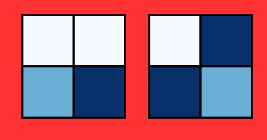

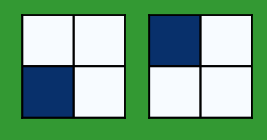

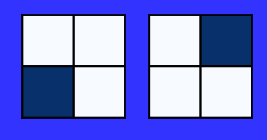

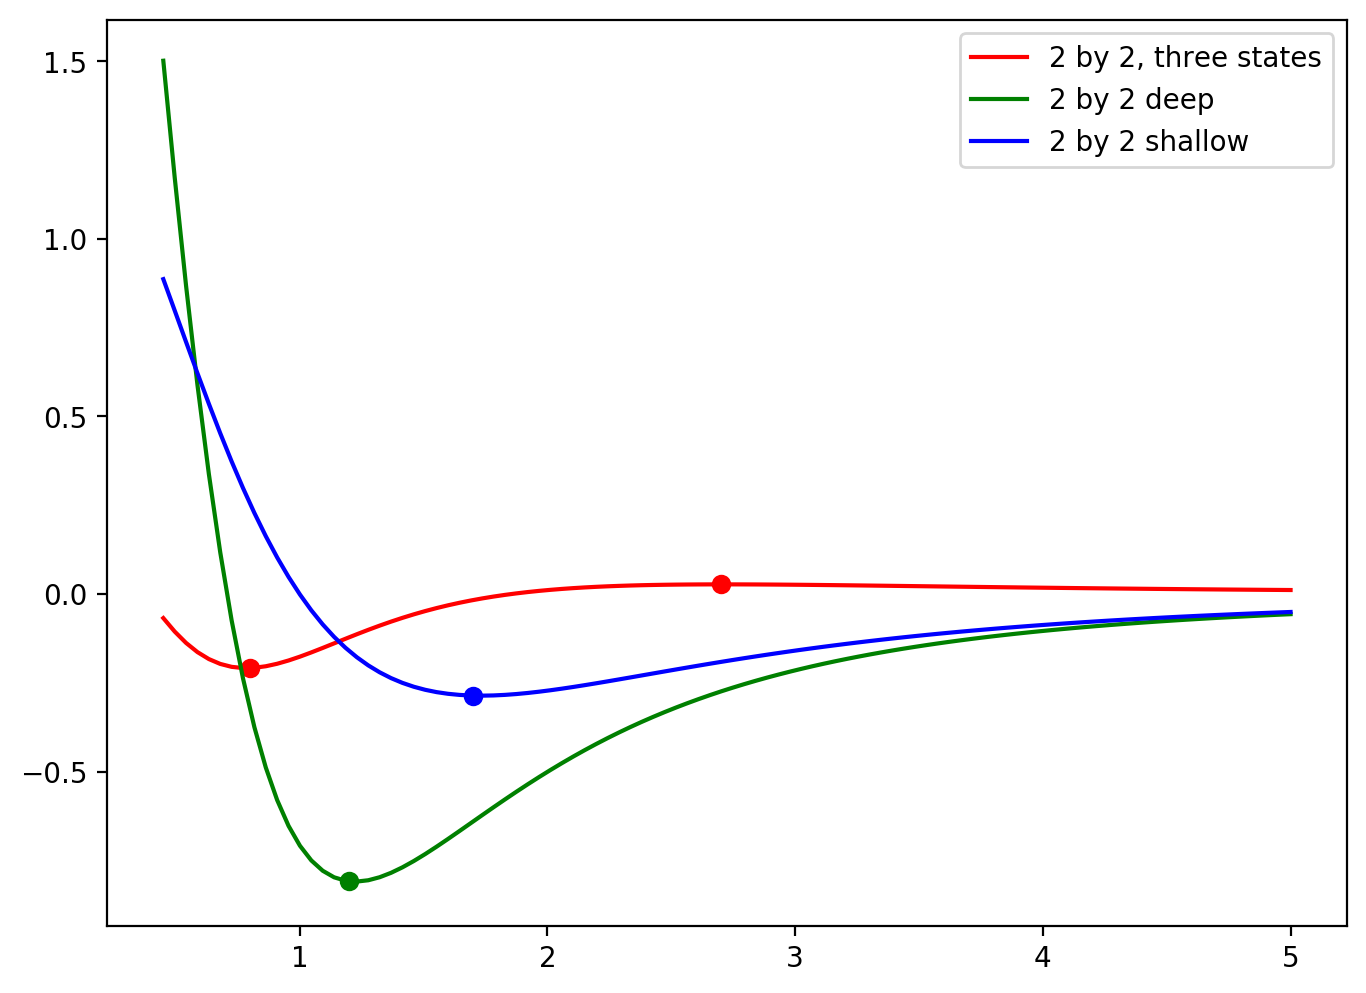

In [63]:
colors=['r','g','b']
i=0
for pads in two_extrema[:1]:
    show_pads(pads[0],pads[1],2,patch_color='r')
    
    show_pads(get_magnet_pad(2,2),get_magnet_pad(2,7)*(-1),2,patch_color='g')
    show_pads(get_magnet_pad(2,2),get_magnet_pad(2,11)*(-1),2,patch_color='b')
    pes=combination_of_single_dipole(x2y2list, outerToBucket(np.outer(pads[0],pads[1]),idxlist)  , dlist, single_dipole_energy)
    info=extrema_info(pes,dlist)
    plt.figure(figsize=(8,6),dpi=200)
    plt.plot(dlist,pes,color=colors[i],label='2 by 2, three states')
    for t in info:
        print(t)
        plt.scatter(t[0],t[1],color=colors[i])
    i+=1
    
    pes=combination_of_single_dipole(x2y2list, outerToBucket(np.outer(get_magnet_pad(2,2),get_magnet_pad(2,7)*(-1)),idxlist)  , dlist, single_dipole_energy)
    info=extrema_info(pes,dlist)
    #plt.figure()
    plt.plot(dlist,pes,color=colors[i],label='2 by 2 deep')
    for t in info:
        print(t)
        plt.scatter(t[0],t[1],color=colors[i])
    i+=1
    
    pes=combination_of_single_dipole(x2y2list, outerToBucket(np.outer(get_magnet_pad(2,2),get_magnet_pad(2,11)*(-1)),idxlist)  , dlist, single_dipole_energy)
    info=extrema_info(pes,dlist)
    #plt.figure()
    plt.plot(dlist,pes,color=colors[i],label='2 by 2 shallow')
    for t in info:
        print(t)
        plt.scatter(t[0],t[1],color=colors[i])
    i+=1
plt.legend()    
    
plt.savefig("figure/2by2_compare.png")   

In [11]:
#assignments = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]
assignments = [[-1,-1],[-1,1],[1,-1],[1,1]]
def combination_unique_pads_TwoStates(N, idxlist):
    """
    Given a set of force, find a subset set S of it,
    such that sum(abs(sign_i F[S_i])) < eps, and sum(sign_i E[S_i]) < targetE)
    
    return:
    (1) a list of selected index : S_i
    (2) a list of corresponding sign for S_i: sign_i

   
    force: a 1-D array
    energy: a 1-D array
    
    targetF: the target value of net force
    targetE: the upper bound of sum of energy
    
    three_states: boolean
    
    eps: the maxium difference between the solution sum with the target.
    
    """
    pad1 = np.zeros([N * N]).astype('int8')
    pad2 = np.zeros([N * N]).astype('int8')
    global base_bucket
    base_bucket = outerToBucket(np.outer(np.ones([N*N]),np.ones([N*N])),idxlist)
    res=set()
    dfs_unique_pads_TwoStates(0, pad1, pad2, res) 
    
    return res


def dfs_unique_pads_TwoStates(idx, pad1, pad2, res):
    global idxlist,base_bucket,assignments
    bucket = outerToBucket(np.outer(pad1,pad2),idxlist)
    
    if (idx == len(pad1)):
        #if (np.any(np.outer(pad1, pad2) != outerproduct)):

         #   print(pad1, pad2)
         #   print(outerproduct)
        
        bucket = outerToBucket(np.outer(pad1,pad2),idxlist)
        res.add(hash_bucket(bucket, base_bucket ))
        
        return
    

    for pair in assignments:
        pad1[idx]=pair[0]
        pad2[idx]=pair[1]
        dfs_unique_pads_TwoStates(idx+1,pad1,pad2, res)
    
    pad1[idx]=0
    pad2[idx]=0




In [27]:

N=3
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads_TwoStates(N, idxlist)
e=time.time()
print(len(res),e-s)


#for r in res:
#    print(backout_bucket(r, base_bucket))

4366 21.94162106513977


In [115]:
0.19/0.0023*60/60

82.60869565217392

In [20]:
N=2
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads_threeStates(N, idxlist)
e=time.time()
print(len(res),e-s)
base=[4,8,4]

153 0.18508172035217285


In [ ]:
compute(get_magnet_pad(2,2), )

In [32]:
from collections import defaultdict
dlist=np.linspace(0.5,5,100)
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
mydict=defaultdict(set)
extremas=np.zeros([4])
for hashval in res:
    bucket=backout_bucket(hashval, base)
    pes = combination_of_single_dipole(x2y2list, bucket, dlist, single_dipole_energy)
    info=extrema_info(pes,dlist)
    extremas[len(info)]+=1
    mydict[len(info)].add(info)
    #plt.plot(dlist,pes)

In [35]:
mydict
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle
    
with open('extrema_2by2_ThreeStates_data.p', 'wb') as fp:
    pickle.dump(mydict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [119]:
N=2
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads_threeStates(N, idxlist)
e=time.time()
print(len(res),e-s)
print(res)

153 0.18116974830627441
{0, 51205, 21002, 21004, 50702, 50703, 50704, 50705, 20503, 71206, 41002, 41003, 41004, 41005, 41006, 10805, 10806, 10807, 40504, 70207, 1600, 61004, 61006, 30802, 30803, 30804, 30805, 30806, 30807, 60505, 21103, 50801, 50802, 50803, 50804, 50805, 50806, 20602, 20604, 80008, 11401, 41104, 70801, 70802, 70803, 40602, 40603, 40604, 40605, 40606, 10402, 61105, 30903, 30904, 30905, 30906, 60604, 60606, 30403, 81608, 21201, 21202, 50902, 50903, 50904, 50905, 20704, 20705, 20706, 50405, 71407, 41204, 11003, 40702, 40703, 40704, 40705, 40706, 70406, 61206, 61207, 31001, 31003, 31004, 31005, 60702, 60703, 60704, 804, 30502, 808, 21302, 51003, 51004, 51005, 51007, 20802, 20803, 20805, 20806, 20807, 50506, 20302, 71005, 40800, 40803, 40804, 40805, 40808, 10603, 61306, 31102, 60801, 60802, 60803, 60805, 60806, 30601, 30603, 30604, 30605, 60306, 80800, 51106, 80804, 20904, 20905, 20906, 50603, 50604, 50605, 50607, 20401, 20402, 11202, 40902, 40903, 40904, 40905, 40906, 7060

In [14]:
N=2
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads_threeStates(N, idxlist)
e=time.time()
print(len(res),e-s)

39 0.021218061447143555


In [15]:
N=2
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads(N, idxlist)
e=time.time()
print(len(res),e-s)

N=2
x2y2list, idxlist = initialize_buckets(gen_2D_pos(N))
s=time.time()
res=combination_unique_pads_threeStates(N, idxlist)
e=time.time()
print(len(res),e-s)
#res

19 0.019028902053833008
39 0.02713799476623535


160
time= 8.33015513420105


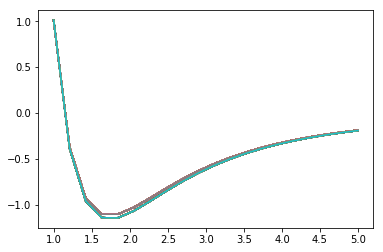

In [136]:
N=3
N2=N**2
dlist=np.array([1.75])
pos_2D=gen_2D_pos(N)
force = gen_derivative_3D_pos(pos_2D, dlist).reshape(N2,N2)
energy = interaction_tensor(pos_2D, dlist).reshape(N2,N2)
dlist2=np.linspace(1,5,20)
tensor_list = interaction_tensor(pos_2D, dlist2)
targetF = 0
targetE = -1.1
eps=0.05
s=time.time()
res=combination_sum_pads(N, force, energy, targetF, targetE, eps,three_states=False)
print(len(res))
e=time.time()
print("time=",e-s)
for pair in res:
    #print(pair)
    pad1 = pair[0]
    pad2 = pair[1]
    pes = energy_tensor_form(pad1, tensor_list, pad2).flatten()
    plt.plot(dlist2,pes,label=str(np.round(pair[2],2))+","+str(np.round(pair[3],2)))

In [138]:
2**16

65536

In [140]:
np.random.rand(2)

array([0.02493936, 0.47383957])

In [143]:
np.random.rand(2,4,3)

array([[[0.6342786 , 0.94798772, 0.1394646 ],
        [0.40014092, 0.99130604, 0.32268619],
        [0.32546461, 0.06277861, 0.05374563],
        [0.558083  , 0.83677308, 0.21839177]],

       [[0.98735606, 0.2009123 , 0.6113295 ],
        [0.3628091 , 0.55062567, 0.9701725 ],
        [0.32256722, 0.83475464, 0.63331214],
        [0.43535334, 0.36470136, 0.69492032]]])